In [8]:
import os
import random
import sys
import torch

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

In [9]:
dir_list = os.listdir('C:\\Users\\satyam\\content\\')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [10]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('C:\\Users\\satyam\\content\\' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'C:\\Users\\satyam\\content\\' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,0,1
1,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,1,1
2,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,0,1
3,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,1,1
4,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,0,2


In [11]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

C:\Users\satyam\content\Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [12]:
len(samples), sample_rate

(77989, 22050)

In [13]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
sample_rate/ len(samples)

0.28273218017925605

In [14]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

NameError: name 'spectrogram' is not defined

In [15]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

NameError: name 'aa' is not defined

In [16]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

NameError: name 'log_S' is not defined

In [17]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [18]:
ipd.Audio(aa, rate=sample_rate)

NameError: name 'aa' is not defined

In [19]:
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [20]:
label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [21]:
label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [22]:
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [23]:
label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [24]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,0,1,male_none
1,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,1,1,male_none
2,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,0,1,male_none
3,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,1,1,male_none
4,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,0,2,male_positive


In [25]:
data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
data2_df = data2_df[data2_df.label != "male_happy"]
data2_df = data2_df[data2_df.label != "male_angry"]
data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 22]
tmp2 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,0,0,2,female_positive
1,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,0,1,2,female_positive
2,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,1,0,2,female_positive
3,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,1,1,2,female_positive
4,C:\Users\satyam\content\Actor_02/03-01-02-02-0...,1,2,female,1,0,0,2,female_positive


In [26]:

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,0,2,male_positive
1,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,1,2,male_positive
2,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,1,0,2,male_positive
3,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,1,1,2,male_positive
4,C:\Users\satyam\content\Actor_01/03-01-02-02-0...,1,1,male,1,0,0,2,male_positive


In [27]:
print (len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,0,0,2,male_positive
1,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,0,1,2,male_positive
2,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,1,0,2,male_positive
3,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,1,1,2,male_positive
4,C:\Users\satyam\content\Actor_21/03-01-02-02-0...,1,21,male,1,0,0,2,male_positive


In [28]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [00:28<00:00, 13.91it/s]


In [29]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-65.447311,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858


In [30]:
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [31]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive
5,-69.243607,-69.243607,-69.243607,-69.243607,-68.902374,-67.983444,-68.089653,-67.897789,-65.258499,-67.171410,...,-57.186440,-61.189224,-67.108902,-67.508621,-66.246048,-68.733475,-69.243607,-69.243607,-69.243607,male_positive
6,-73.255318,-73.255318,-73.255318,-73.255318,-68.774933,-69.380905,-73.255318,-73.255318,-73.255318,-73.255318,...,-50.886692,-55.668213,-54.602642,-53.441689,-56.299820,-57.457932,-58.767605,-59.844345,-59.074680,male_positive
7,-70.746674,-70.746674,-70.025597,-69.131645,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,...,-70.746674,-70.746674,-70.079544,-69.590736,-69.203033,-70.159676,-70.445572,-68.199638,-67.593987,male_positive
8,-63.787254,-63.128746,-63.412743,-63.797016,-63.582291,-58.921696,-57.955513,-61.225422,-63.783241,-63.797016,...,-63.740913,-62.410637,-62.489479,-62.494827,-62.633003,-62.878506,NaN,NaN,NaN,male_positive
9,-60.981300,-60.116249,-60.978966,-60.952496,-60.982536,-60.983990,-60.981300,-60.981300,-60.981300,-60.249794,...,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,NaN,NaN,NaN,male_positive


In [32]:
rnewdf.isnull().sum().sum()

2284

In [33]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive


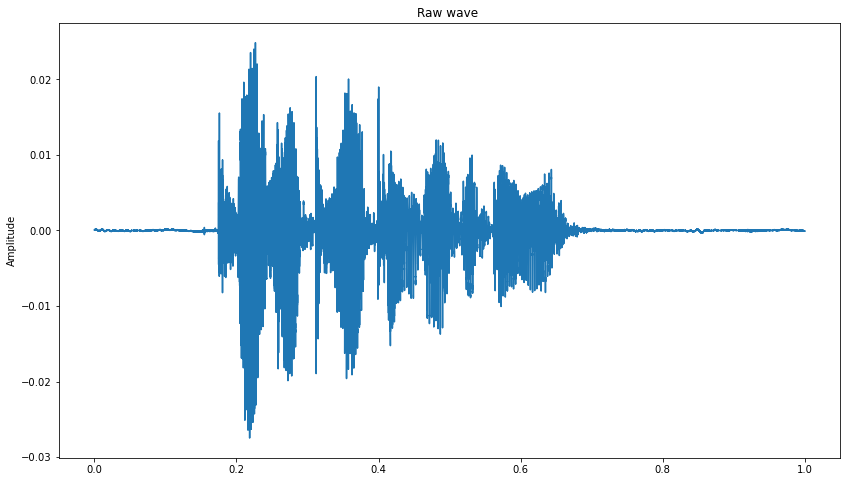

In [34]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error



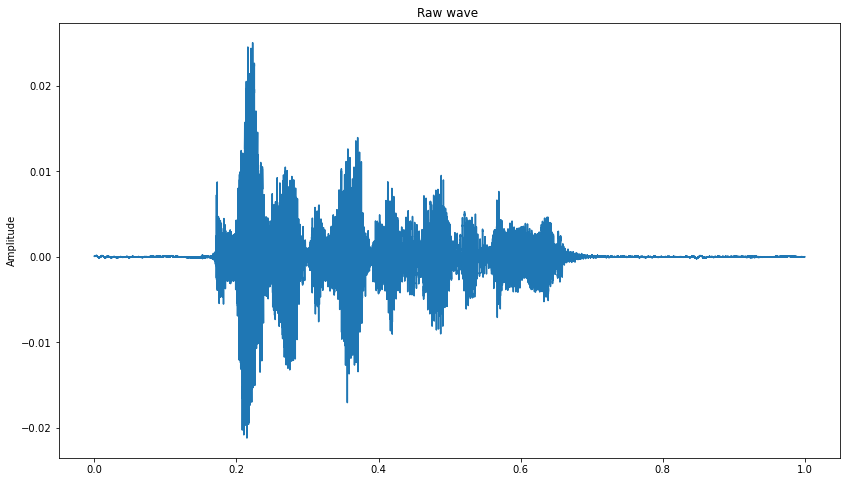

In [35]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [36]:
syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [00:32<00:00, 12.48it/s]


In [37]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

  0%|          | 0/400 [00:00<?, ?it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  0%|          | 2/400 [00:00<03:03,  2.17it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  1%|          | 3/400 [00:01<03:13,  2.05it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  1%|          | 4/400 [00:01<03:08,  2.10it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  1%|▏         | 5/400 [00:02<03

  9%|▉         | 35/400 [00:19<03:01,  2.01it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  9%|▉         | 36/400 [00:19<02:57,  2.05it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

  9%|▉         | 37/400 [00:20<03:00,  2.01it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 10%|▉         | 38/400 [00:21<03:13,  1.87it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 10%|▉         | 39/

 17%|█▋        | 69/400 [00:37<02:52,  1.92it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 18%|█▊        | 70/400 [00:38<02:52,  1.92it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 18%|█▊        | 71/400 [00:38<02:58,  1.84it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 18%|█▊        | 72/400 [00:39<02:57,  1.85it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 18%|█▊        | 73/

 26%|██▌       | 103/400 [00:54<02:24,  2.06it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 26%|██▌       | 104/400 [00:54<02:20,  2.11it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 26%|██▋       | 105/400 [00:55<02:31,  1.94it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 26%|██▋       | 106/400 [00:56<02:38,  1.86it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 27%|██▋       |

 34%|███▍      | 137/400 [01:12<02:17,  1.91it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 34%|███▍      | 138/400 [01:12<02:23,  1.82it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 35%|███▍      | 139/400 [01:13<02:21,  1.84it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 35%|███▌      | 140/400 [01:13<02:16,  1.91it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 35%|███▌      |

 43%|████▎     | 171/400 [01:30<01:55,  1.98it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 43%|████▎     | 172/400 [01:30<01:50,  2.07it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 43%|████▎     | 173/400 [01:31<01:54,  1.98it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 44%|████▎     | 174/400 [01:31<01:51,  2.02it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 44%|████▍     |

 51%|█████▏    | 205/400 [01:48<01:45,  1.86it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 52%|█████▏    | 206/400 [01:48<01:35,  2.03it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 52%|█████▏    | 207/400 [01:49<01:33,  2.06it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 52%|█████▏    | 208/400 [01:49<01:30,  2.13it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 52%|█████▏    |

 60%|█████▉    | 239/400 [02:05<01:19,  2.01it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 60%|██████    | 240/400 [02:06<01:17,  2.05it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 60%|██████    | 241/400 [02:06<01:14,  2.13it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 60%|██████    | 242/400 [02:06<01:13,  2.16it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 61%|██████    |

 68%|██████▊   | 273/400 [02:22<01:09,  1.83it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 68%|██████▊   | 274/400 [02:23<01:05,  1.91it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 69%|██████▉   | 275/400 [02:23<01:05,  1.90it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 69%|██████▉   | 276/400 [02:24<01:04,  1.93it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 69%|██████▉   |

 77%|███████▋  | 307/400 [02:40<00:51,  1.80it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 77%|███████▋  | 308/400 [02:41<00:49,  1.85it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 77%|███████▋  | 309/400 [02:42<00:53,  1.70it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 78%|███████▊  | 310/400 [02:42<00:55,  1.63it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 78%|███████▊  |

 85%|████████▌ | 341/400 [02:58<00:33,  1.74it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 86%|████████▌ | 342/400 [02:58<00:30,  1.92it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 86%|████████▌ | 343/400 [02:59<00:29,  1.90it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 86%|████████▌ | 344/400 [03:00<00:30,  1.84it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 86%|████████▋ |

 94%|█████████▍| 375/400 [03:16<00:14,  1.71it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 94%|█████████▍| 376/400 [03:17<00:13,  1.81it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 94%|█████████▍| 377/400 [03:17<00:11,  1.98it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 94%|█████████▍| 378/400 [03:18<00:10,  2.04it/s]C:\Users\satyam\AppData\Local\Temp\ipykernel_20220\3110203251.py:42: FutureWarning:

Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error

 95%|█████████▍|

In [38]:
len(syn_data1), len(syn_data2) 

(400, 400)

In [39]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [40]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [41]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive


In [42]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


NameError: name 'train_test_split' is not defined

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_train

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1)))== 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
# Plotting Model Summary

model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [ ]:

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=70,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

In [ ]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

In [ ]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

In [ ]:
preds

In [ ]:
preds1=preds.argmax(axis=1)
preds1

In [ ]:
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

In [ ]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

In [ ]:
finaldf = actualdf.join(preddf)

In [ ]:
finaldf[20:40]

In [ ]:
finaldf.groupby('actualvalues').count()

In [ ]:
finaldf.groupby('predictedvalues').count()

In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

In [ ]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

In [ ]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)
